In [271]:
import numpy as np
from matplotlib import pyplot as plt

## Q2

## a)

The below function returns the greens function for a grid of dimensions ndim and size of each dimension n

In [272]:
def greens(n, ndim=2):
    dx=np.arange(n)
    dx[n//2:]=dx[n//2:]-n
    if ndim==2:
        pot=np.zeros([n,n])
        xmat,ymat=np.meshgrid(dx,dx)
        dr=np.sqrt(xmat**2+ymat**2)
        dr[0,0]=1 
        pot=-np.log(dr)/2/np.pi
        pot[0,0]=pot[1,0] + 0.25 
        return pot

I make a grid of 100X100. I initially set dr[0,0]=1 so that log of dr does not give an error at (0,0). Since the potential goes as -log(r) for 2D point charge and we set epsilon to 1, the potential at every point is just -log(r)/2*pi. Potential at (0,0) can be found by using the formula v(0,0) = charge(0,0) + V_avg_neighbours. Since we are considering charge at (0,0) to be 1, and since the neighbours of (0,0) are (1,0), (0,1), (-1,0), (0,-1) which all have the same potential, this gives the V at (0,0) to be (4*V(1,0)/4) + 0.25 (as Laplacian in 2D picks up rho/4 at zero point)

In [273]:
pot = greens(100,2)
print("Potential at (0,0) is {}".format(pot[0,0]))

Potential at (0,0) is 0.25


To get V at (0,0) to be 1, I rescale the potential -- multiply it by 4

Text(0.5, 1.0, 'Potential')

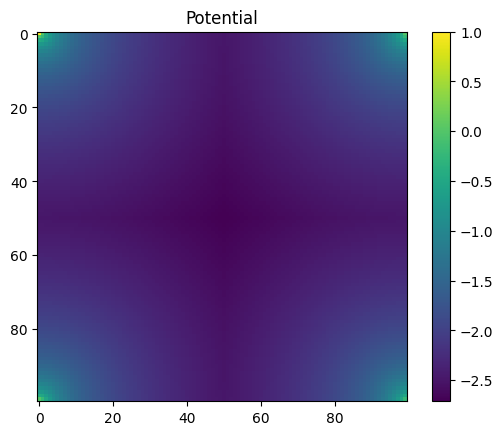

In [274]:
pot = 4*pot
plt.imshow(pot)
plt.colorbar()
plt.title("Potential")

In [275]:
print("V at (1,0) = {}\nV at (2,0) = {}\nV at (5,0) = {}\n".format(pot[1,0], pot[2,0], pot[5,0]))

V at (1,0) = -0.0
V at (2,0) = -0.4412712003053032
V at (5,0) = -1.0245999974535522



As can be seen, this almost satisfies the sanity check for V at (5,0)!

## b)

Some helper functions

Function which will convolve the green's function with the charge denisty to give the potential

In [276]:
def rho2pot(rho,kernelft):
    tmp=rho.copy()
    tmp=np.pad(tmp,(0,tmp.shape[0]))

    tmpft=np.fft.rfftn(tmp)
    tmp=np.fft.irfftn(tmpft*kernelft)
    tmp=tmp[:rho.shape[0],:rho.shape[1]]
    return tmp

The function calls the rho2pot function with the charge only on the boundary and returns the corresponding potential from the charge on the boundary

In [277]:
def rho2pot_masked(rho,mask,kernelft,return_mat=False):
    rhomat=np.zeros(mask.shape)
    rhomat[mask]=rho
    potmat=rho2pot(rhomat,kernelft)
    if return_mat:
        return potmat
    else:
        return potmat[mask]

Function which does the conjugate gradient to solve Ax=b where A is the Laplacian. Since we want to find the charge distribution, the potential V will be b and the charge density rho will be the x

In [278]:
def cg(rhs,x0,mask,kernelft,niter,fun=rho2pot_masked,show_steps=False,step_pause=0.01):
    Ax=fun(x0,mask,kernelft)
    r=rhs-Ax
    p=r.copy()
    x=x0.copy()
    rsqr=np.sum(r*r)
    print('starting rsqr is ',rsqr)
    for k in range(niter):

        Ap=fun(p,mask,kernelft)
        alpha=np.sum(r*r)/np.sum(Ap*p)
        x=x+alpha*p
        if show_steps:            
            tmp=fun(x,mask,kernelft,True)
            plt.imshow(tmp,vmin=-2.1,vmax=2.1)
            plt.colorbar()
            plt.title('rsqr='+repr(rsqr)+' on iter '+repr(k+1))
            plt.savefig('laplace_iter_1024_'+repr(k+1)+'.png')
            plt.pause(step_pause)
        plt.show()
        r=r-alpha*Ap
        rsqr_new=np.sum(r*r)
        beta=rsqr_new/rsqr
        p=r+beta*p
        rsqr=rsqr_new
    print('final rsqr is ',rsqr)
    return x

Given the appropriate boundary conditions, the above functions will solve for the charge on the boundary given the potential on the boundary. Defining the boundary as a square box held at a potential of 1:

Text(0.5, 1.0, 'Box held at potential of 1')

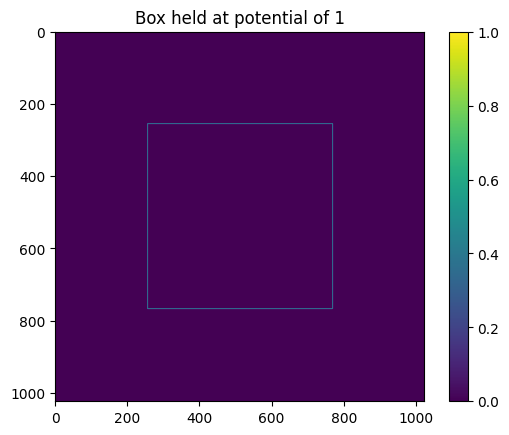

In [279]:
n=1024
bc=np.zeros([n,n])
mask=np.zeros([n,n],dtype='bool')
mask[0,:]=True
mask[-1,:]=True
mask[:,0]=True
mask[:,-1]=True
bc[0,0]=0.0
bc[0,-1]=0.0
bc[-1,0]=0.0
bc[-1,-1]=0.0
#This adds a bar in the interior held at fixed potential
bc[n//4:3*n//4,n//4]=1.0
mask[n//4:3*n//4,n//4]=True
bc[n//4:3*n//4,3*n//4]=1.0
mask[n//4:3*n//4,3*n//4]=True
bc[n//4,n//4:3*n//4]=1.0
mask[n//4,n//4:3*n//4]=True
bc[3*n//4,n//4:3*n//4]=1.0
mask[3*n//4,n//4:3*n//4]=True
plt.imshow(bc)
plt.colorbar()
plt.title("Box held at potential of 1")

First getting the green's function for the appropriate dimensions. Then defining the b of Ax=b (rhs) as the potential on the boundary. And solving for rho:

starting rsqr is  2047.0


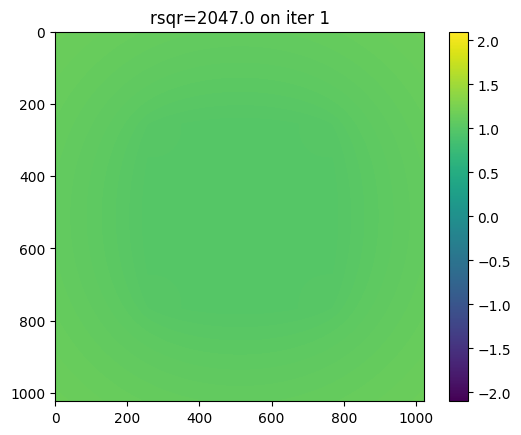

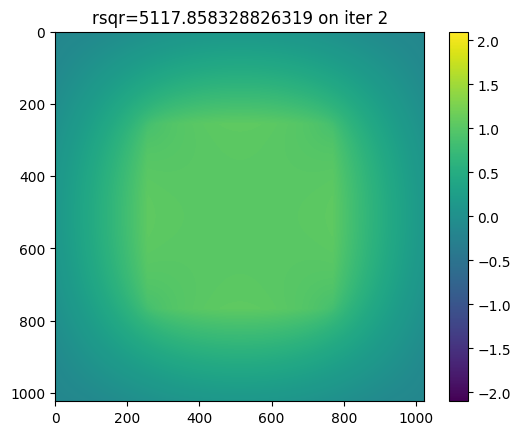

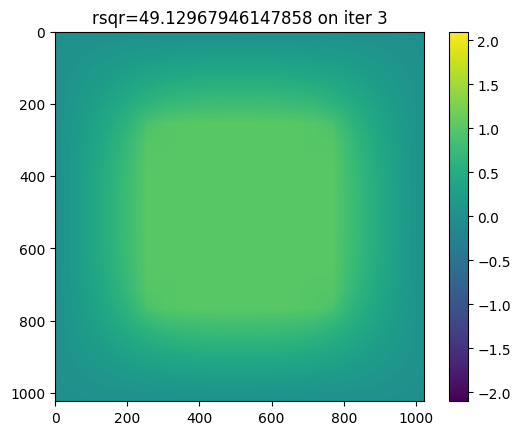

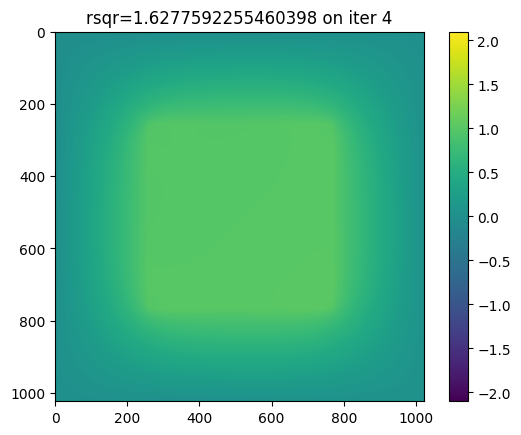

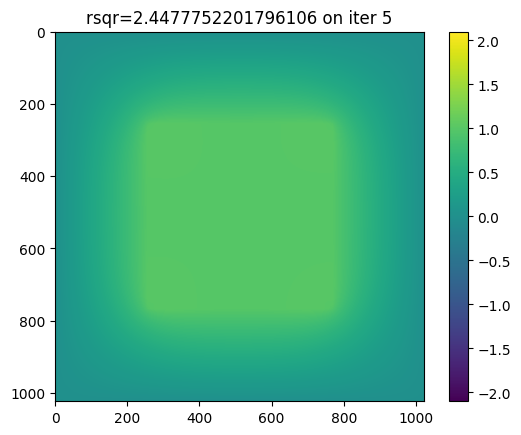

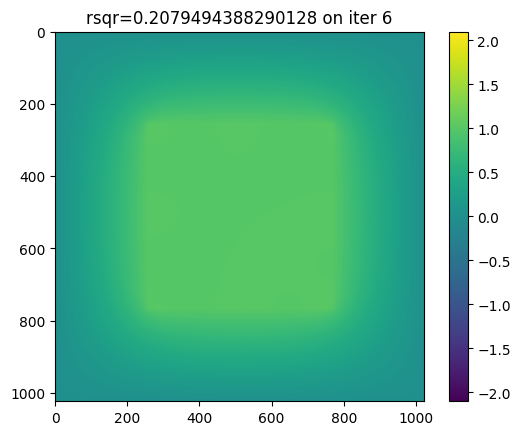

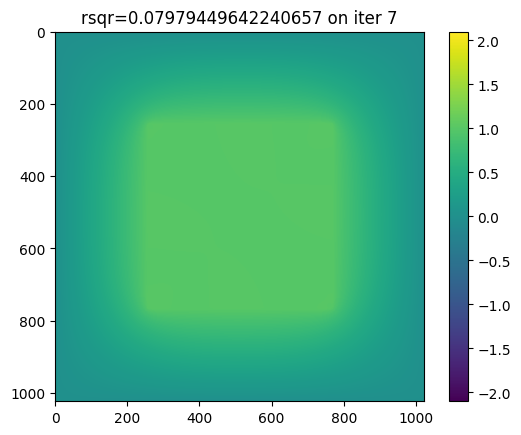

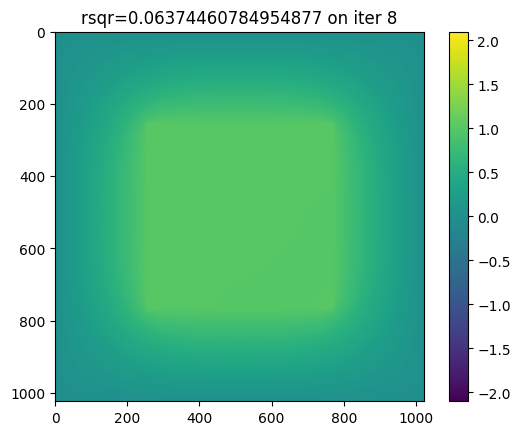

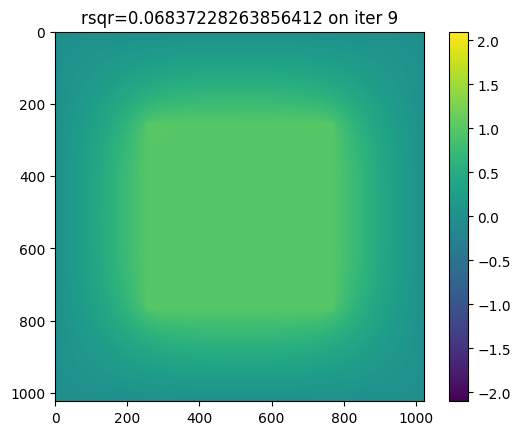

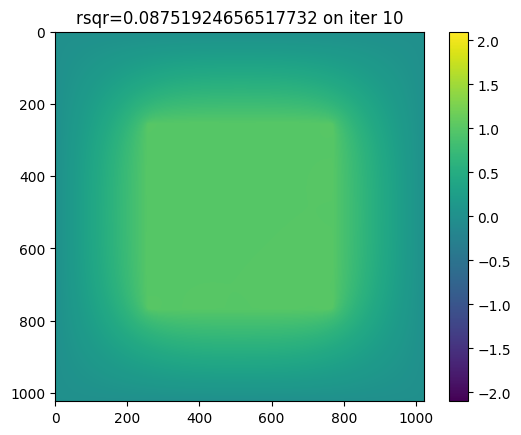

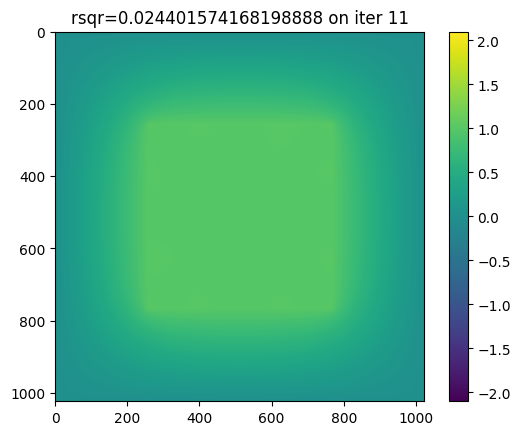

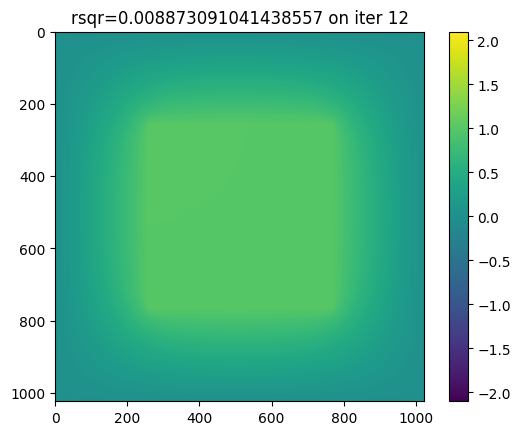

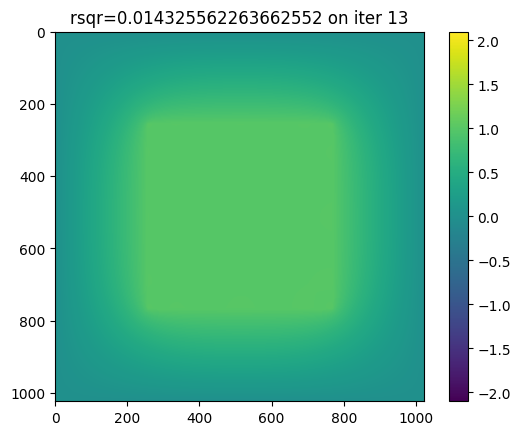

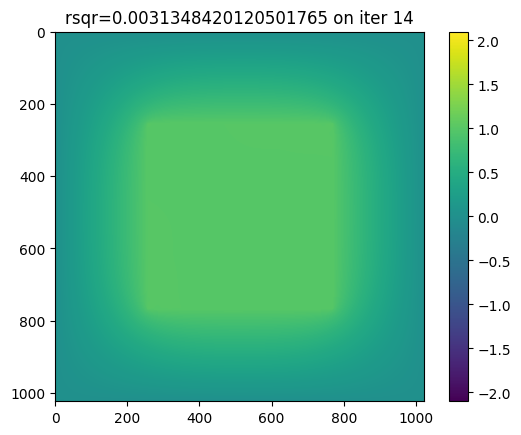

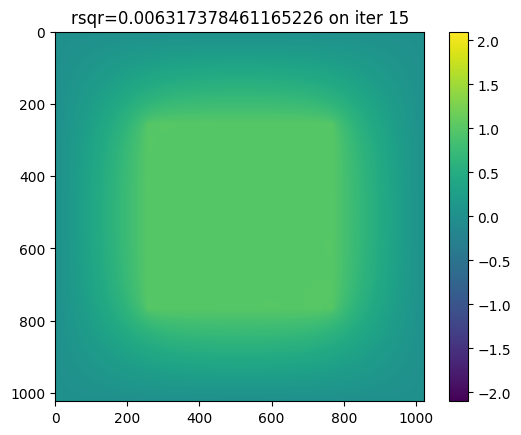

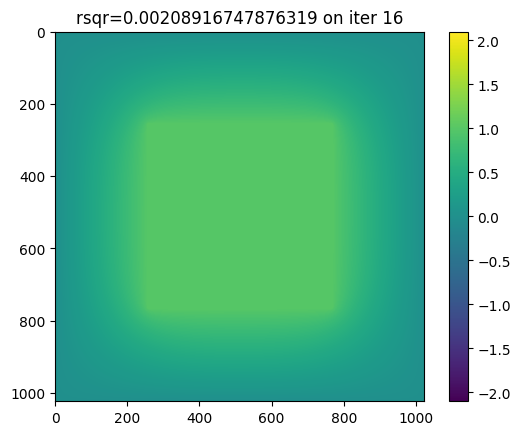

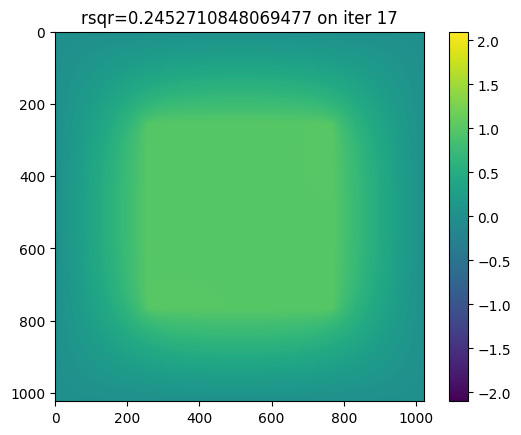

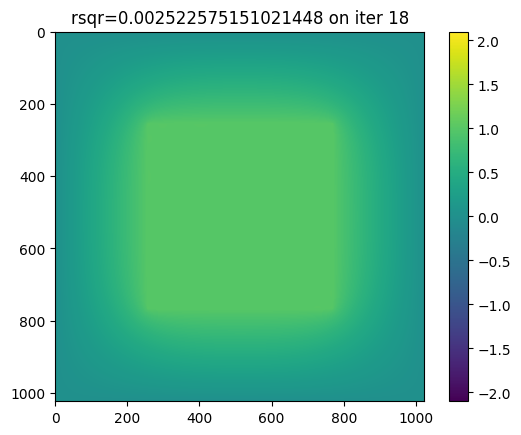

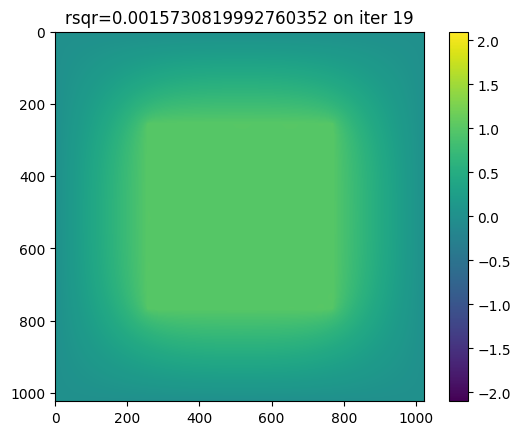

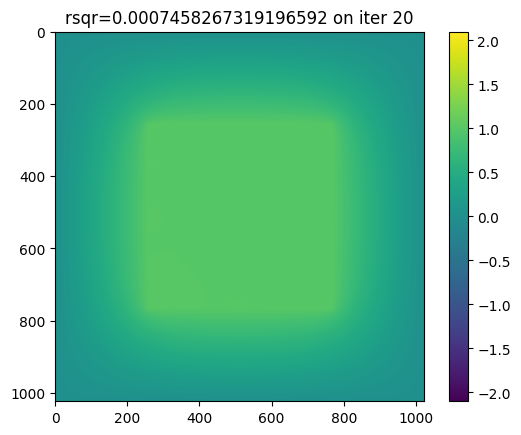

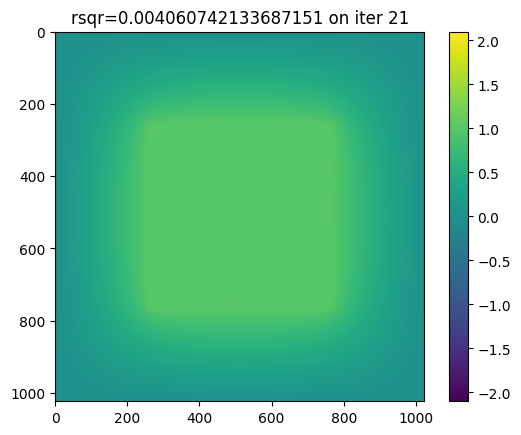

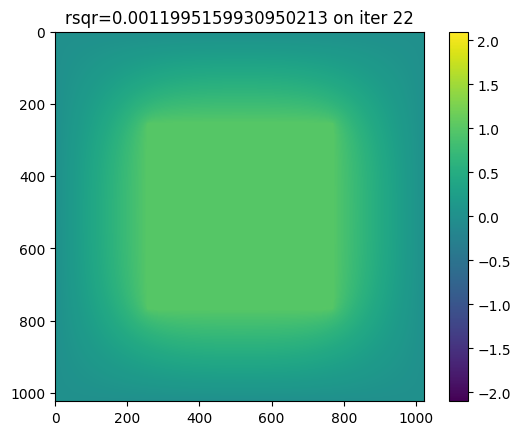

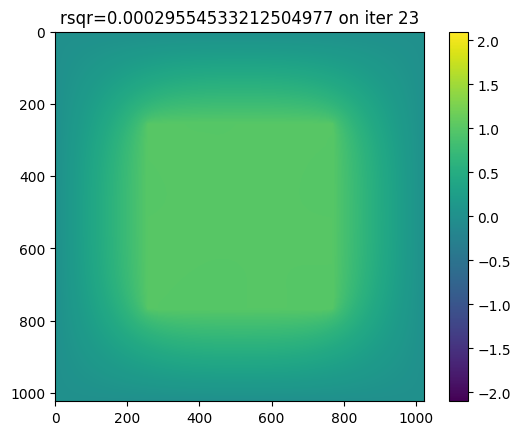

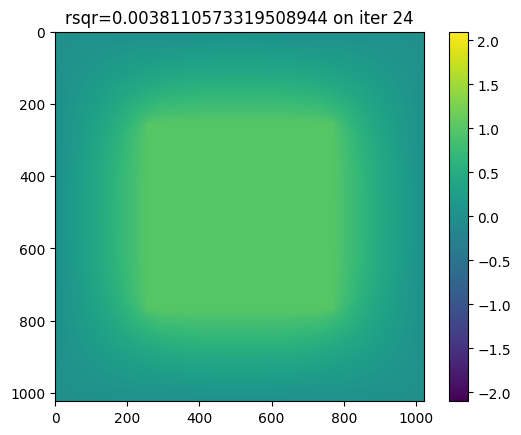

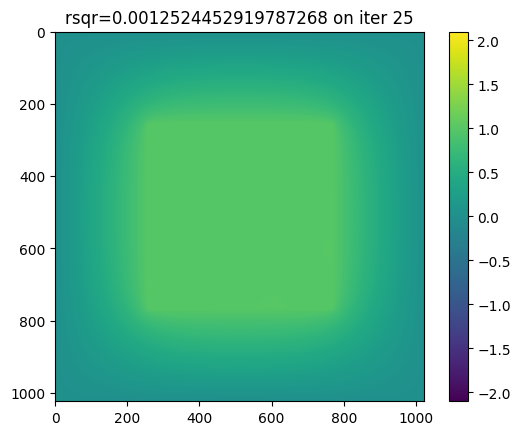

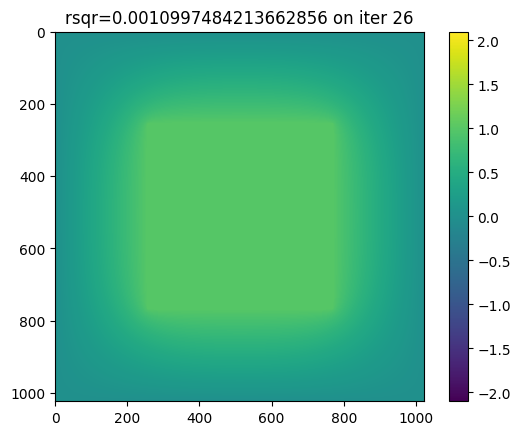

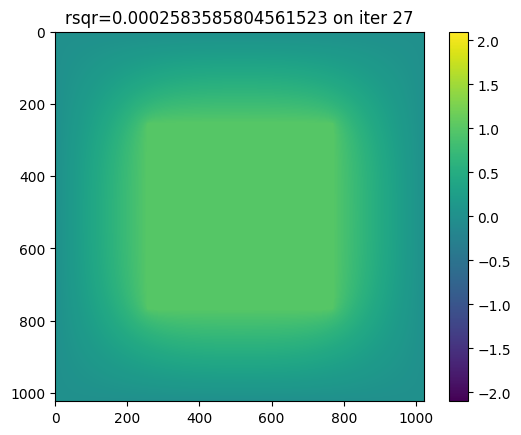

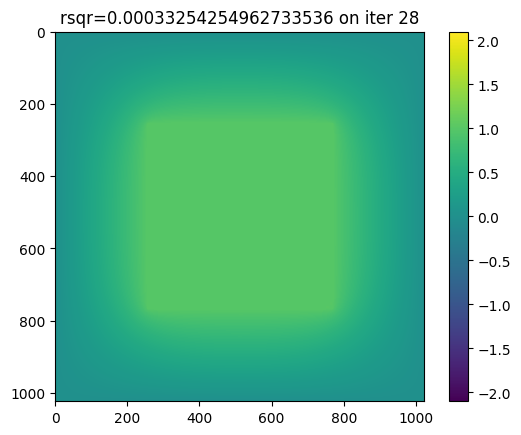

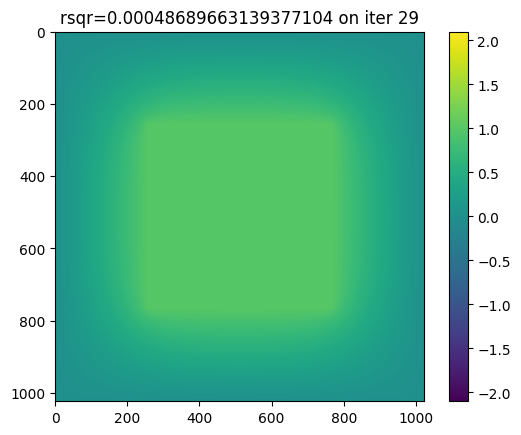

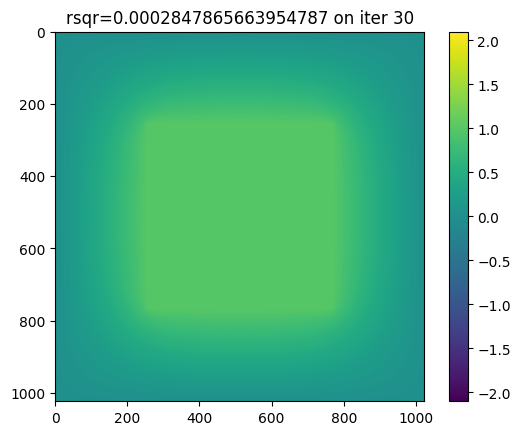

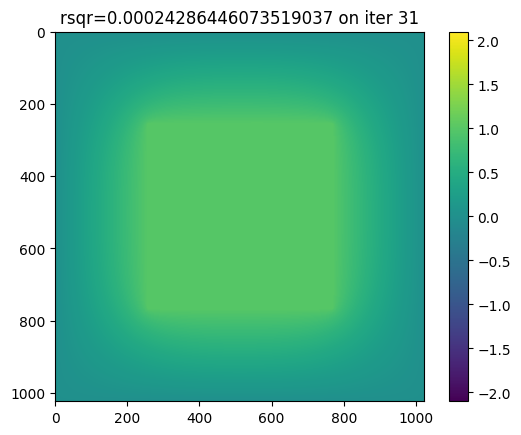

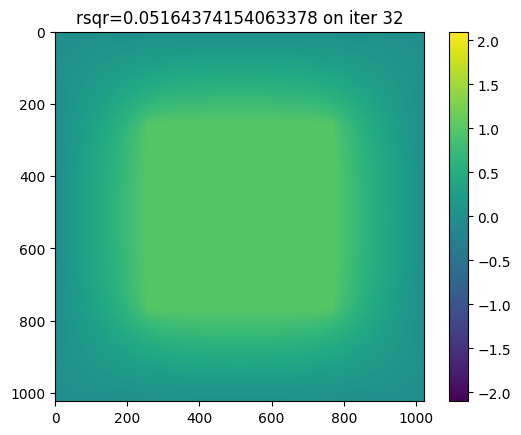

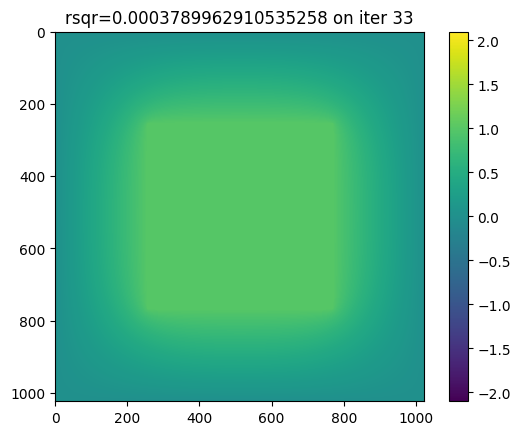

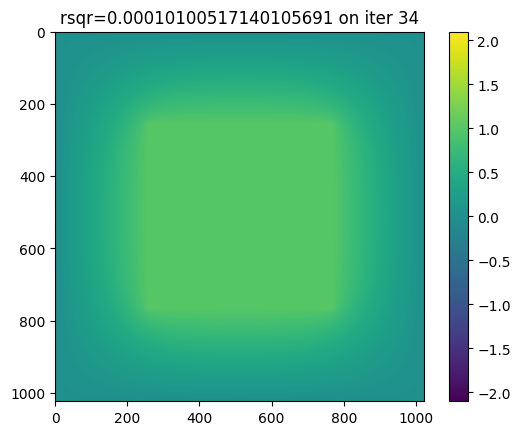

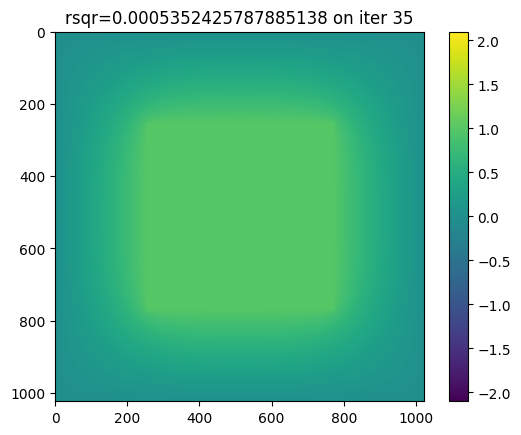

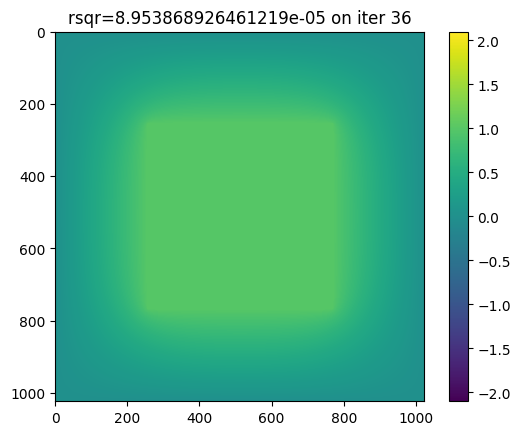

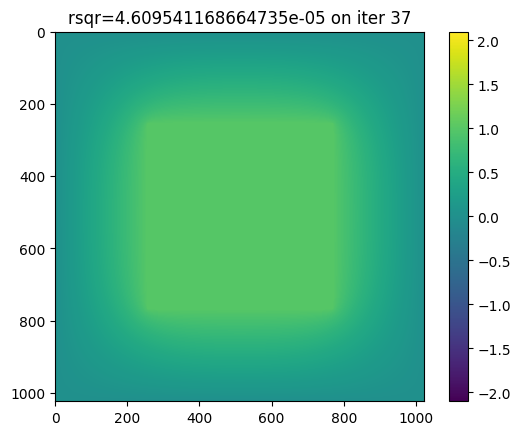

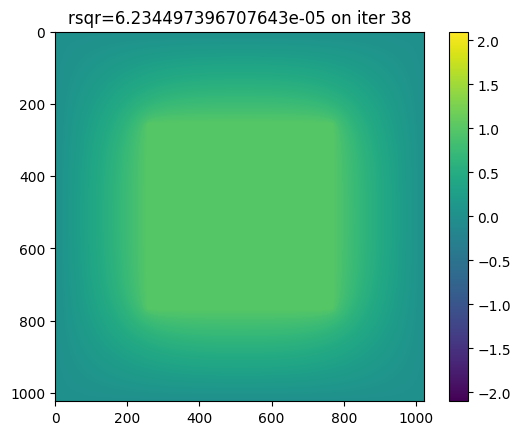

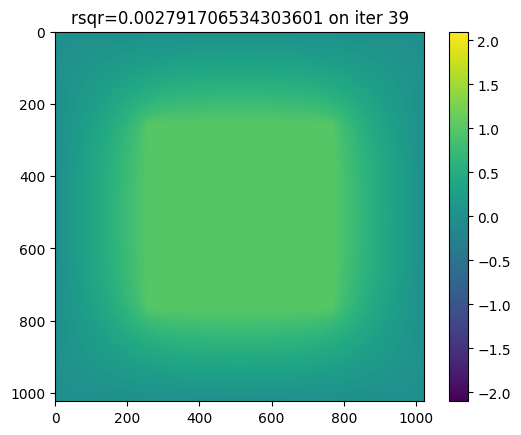

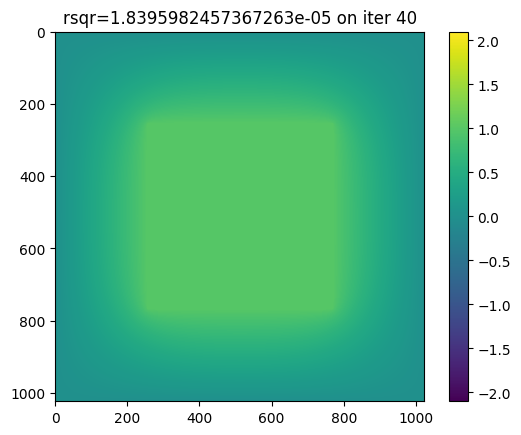

final rsqr is  0.00010513260959439755


In [280]:
kernel=greens(2*n,2)
kernelft=np.fft.rfft2(kernel)
rhs=bc[mask]
x0=0*rhs
rho_out=cg(rhs,x0,mask,kernelft,40,show_steps=True,step_pause=0.25)

Text(0.5, 1.0, 'Charge density along one side of the box')

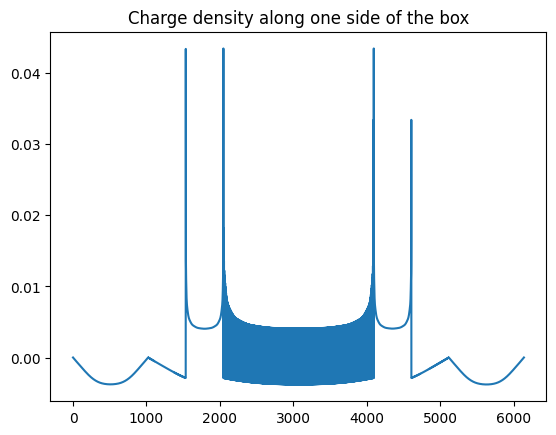

In [281]:
plt.plot(rho_out)
plt.title("Charge density along one side of the box")

## c)

Using this charge to find the potential everywhere in space:

Text(0.5, 1.0, 'Plot 1: Potential everywhere in space')

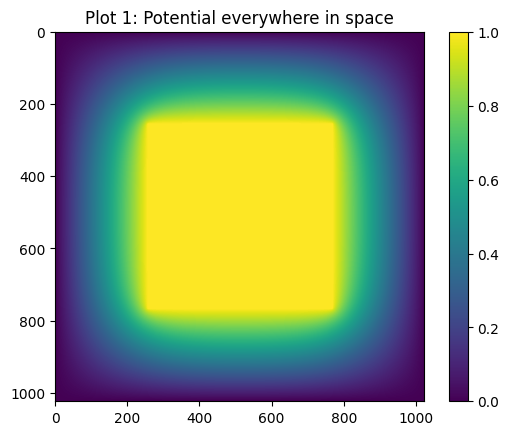

In [282]:
pot=rho2pot_masked(rho_out,mask,kernelft,True)
plt.imshow(pot)
plt.colorbar()
plt.title("Plot 1: Potential everywhere in space")

Text(0.5, 1.0, 'Plot 2: Plot with potential 1 inside the box')

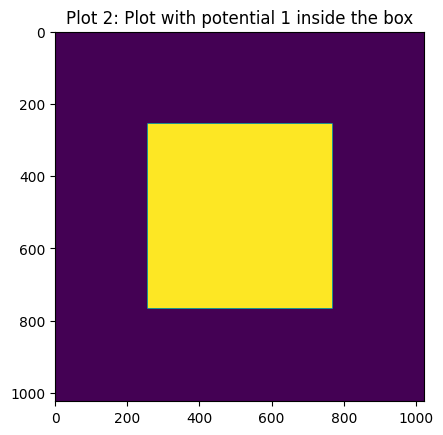

In [283]:
pot_tmp = np.zeros([n,n])
pot_tmp[n//4:3*n//4,n//4:3*n//4] = 1
plt.imshow(pot_tmp)
plt.title("Plot 2: Plot with potential 1 inside the box")

Text(0.5, 1.0, 'Plot 1 - Plot 2')

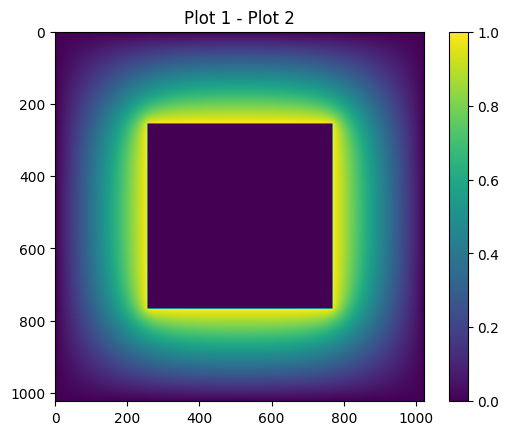

In [284]:
diff = pot - pot_tmp
plt.imshow(diff)
plt.colorbar()
plt.title("Plot 1 - Plot 2")

As can be seen from the above graphs, the potential inside the box is 1. 

Since the electric field is the gradient of V, Ex = (V(x+1) - V(x))/dx and Ey = (V(y+1) - V(y))/dy:

Text(0.5, 1.0, 'Electric field in y-direction')

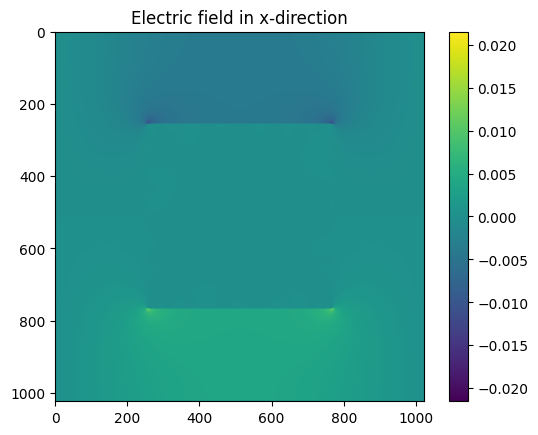

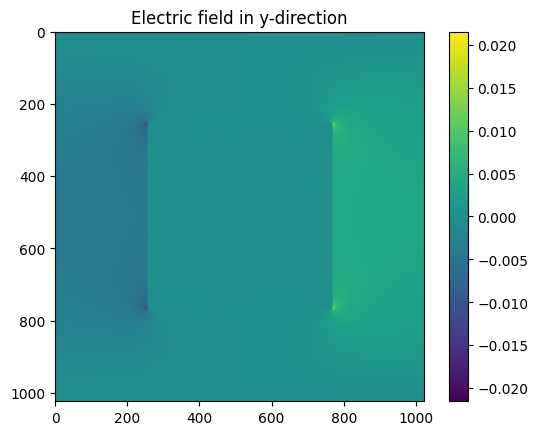

In [285]:
Ex = pot - np.roll(pot,-1,0)
Ey = pot - np.roll(pot, -1, -1)
plt.imshow(Ex)
plt.colorbar()
plt.title("Electric field in x-direction")
plt.figure()
plt.imshow(Ey)
plt.colorbar()
plt.title("Electric field in y-direction")

As can be seen, the field is perpendicular to the equipotential surface of the square box and is thus as expected